# PM2.5 prediction

### Import libraries

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from scipy.stats import stats
seed(1)
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Data Import

In [2]:
data = gpd.read_file('grids/'+ 'grid_cams_0418_0425_2021.gpkg')

data = data[~data['pm25_st'].isnull()]
data = data.dropna(axis=1)

label_selected = ''

data.pop('geometry')
data.pop('bottom')
data.pop('top')
data.pop('left')
data.pop('right')

labels = pd.read_csv('results/grid_cams_0418_0425_2021.csv')
#read variables which are not null
score_results = pd.DataFrame()

#Store dataset in x and y variables
X = pd.DataFrame(data=data, columns=data.columns.tolist() )
Y = X['pm25_st']
Y = Y.values.ravel()
X.pop('pm25_st')
X.pop('lat_cen')
X.pop('lng_cen')
X = pd.DataFrame(data=X, columns=labels['Features'])


In [3]:
y1 = np.array(Y)

X_train, X_val, y_train, y_val = train_test_split(X, y1)

y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)


MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 81        
_________________________________________________________________
dense_1 (Dense)              (None, 280)               2800      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 281       
Total params: 3,162
Trainable params: 3,162
Non-trainable params: 0
_________________________________________________________________
Train on 16 samples, validate on 5 samples
Epoch 1/30


2022-05-03 19:30:45.218238: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 19:30:45.218865: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


16/16 [==============================] - 1s 58ms/sample - loss: 0.2049 - mse: 0.2049 - mae: 0.3771 - val_loss: 0.1794 - val_mse: 0.1794 - val_mae: 0.3909
Epoch 2/30
16/16 [==============================] - 0s 2ms/sample - loss: 0.1896 - mse: 0.1896 - mae: 0.3589 - val_loss: 0.1635 - val_mse: 0.1635 - val_mae: 0.3696
Epoch 3/30
16/16 [==============================] - 0s 2ms/sample - loss: 0.1750 - mse: 0.1750 - mae: 0.3423 - val_loss: 0.1483 - val_mse: 0.1483 - val_mae: 0.3480
Epoch 4/30
16/16 [==============================] - 0s 2ms/sample - loss: 0.1611 - mse: 0.1611 - mae: 0.3262 - val_loss: 0.1339 - val_mse: 0.1339 - val_mae: 0.3261
Epoch 5/30
16/16 [==============================] - 0s 2ms/sample - loss: 0.1479 - mse: 0.1479 - mae: 0.3099 - val_loss: 0.1204 - val_mse: 0.1204 - val_mae: 0.3040
Epoch 6/30
16/16 [==============================] - 0s 2ms/sample - loss: 0.1354 - mse: 0.1354 - mae: 0.2935 - val_loss: 0.1077 - val_mse: 0.1077 - val_mae: 0.2817
Epoch 7/30
16/16 [========

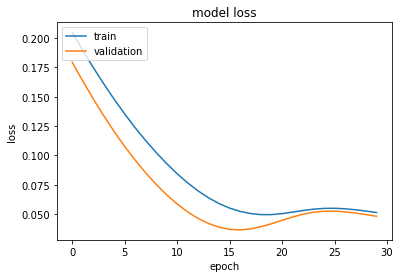

In [4]:
model = Sequential()
model.add(Dense(9, input_dim=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(280, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

